In [136]:
import cv2
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator

#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [137]:
plt.rcParams['figure.figsize'] = [7, 7]

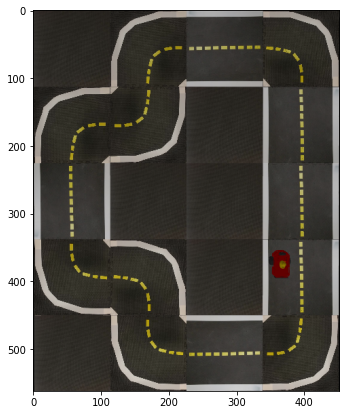

In [138]:
import utils

env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
)

env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], -np.pi/2]
env.reset()
plt.imshow(utils.get_top_view(env))

/home/giulio/prog/duckrace/utils.py:316: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


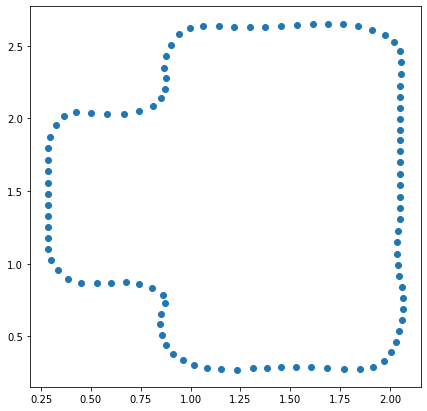

In [139]:
traj = utils.get_trajectory(env, samples=100, method="distance", last_value_distance=0.995)
plt.scatter(*traj.T)

In [140]:
img = cv2.imread("assets/lab_wt.png")
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

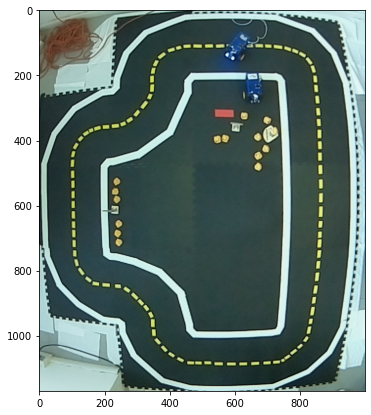

In [141]:
cut = [430,1600,300,1300]
plt.imshow(img_rgb[cut[0]:cut[1], cut[2]:cut[3]])

In [142]:
#img = img[cut[0]:cut[1], cut[2]:cut[3]]

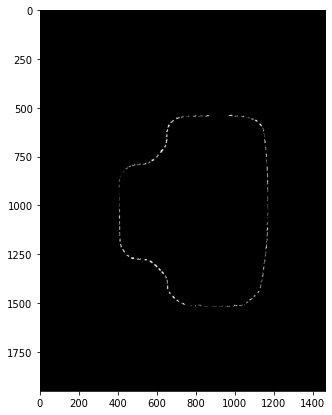

In [143]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hsv_color1 = np.array([35, 70, 210])
hsv_color2 = np.array([60, 250, 250])

mask = cv2.inRange(img_hsv, hsv_color1, hsv_color2)

plt.imshow(mask, cmap='gray')

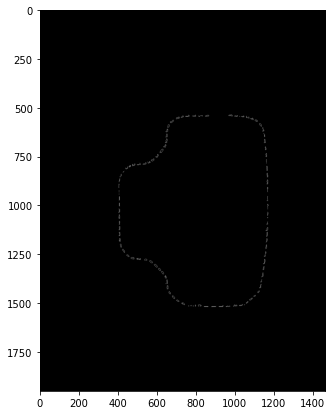

In [145]:
low_threshold = 89
high_threshold = 80
edges = cv2.Canny(mask, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

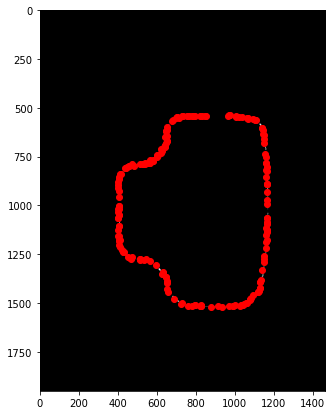

In [146]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 90  # angular resolution in radians of the Hough grid
threshold = 10  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 30  # minimum number of pixels making up a line
max_line_gap = 15  # maximum gap in pixels between connectable line segments

lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

_points = lines.reshape(-1, 2)

x, y = _points.T
plt.scatter(x, y, zorder=1, color="r")
plt.imshow(mask, zorder=0, cmap='gray')

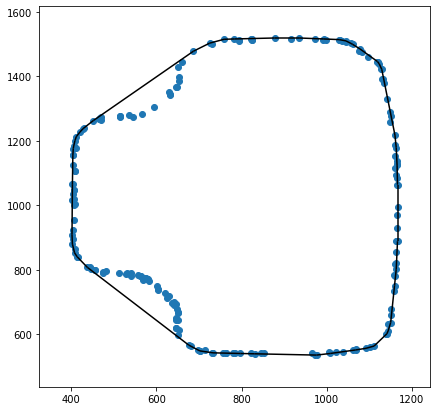

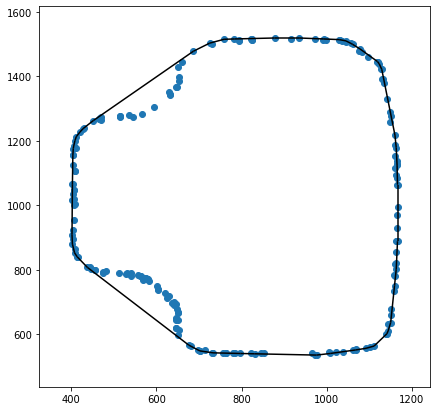

In [147]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(points=_points)

fig, ax = plt.subplots()

convex_hull_plot_2d(hull, ax=ax)

In [148]:
borders = _points[hull.vertices]

In [149]:
borders[:,0].max()

1166

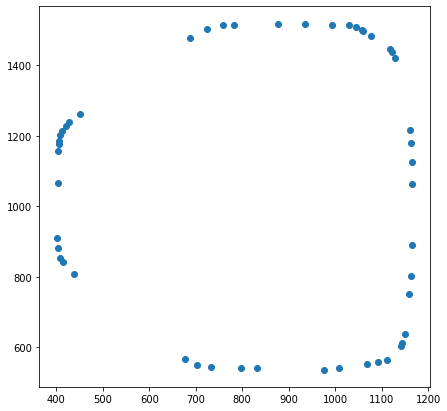

In [150]:
plt.scatter(*borders.T)

In [151]:
scale_x = (borders[:,0].max()-borders[:,0].min())/(traj[:,0].max()-traj[:,0].min())
scale_x

429.13819929792544

In [152]:
scale_y = (borders[:,1].max()-borders[:,1].min())/(traj[:,1].max()-traj[:,1].min())
scale_y

413.1130974069479

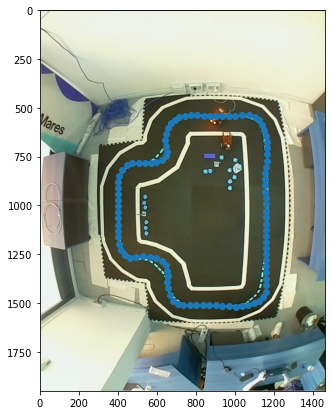

In [153]:
import copy

plt.imshow(img)
traj_scaled = copy.copy(traj)
traj_scaled[:,0] = traj_scaled[:,0]*scale_x
traj_scaled[:,1] = traj_scaled[:,1]*scale_y

offset_x = borders[:,0].min() - traj_scaled[:,0].min()
offset_y = borders[:,1].min() - traj_scaled[:,1].min()

traj_scaled[:,0] += offset_x
traj_scaled[:,1] += offset_y

plt.scatter(*traj_scaled.T)

In [155]:
def calibrate_track(env, traj, img):
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 90  # angular resolution in radians of the Hough grid
    threshold = 10  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30  # minimum number of pixels making up a line
    max_line_gap = 15  # maximum gap in pixels between connectable line segments
    
    cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Range for yellow
    hsv_color1 = np.array([35, 70, 210])
    hsv_color2 = np.array([60, 250, 250])

    mask = cv2.inRange(img_hsv, hsv_color1, hsv_color2)

    linee = cv2.bitwise_and(img, img,mask=mask)
    
    low_threshold = 89
    high_threshold = 80
    edges = cv2.Canny(mask, low_threshold, high_threshold)

    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

    _points = lines.reshape(-1, 2)
    hull = ConvexHull(points=_points)
    
    borders = _points[hull.vertices]
    scale_x = (borders[:,0].max()-borders[:,0].min())/(traj[:,0].max()-traj[:,0].min())
    scale_y = (borders[:,1].max()-borders[:,1].min())/(traj[:,1].max()-traj[:,1].min())
    
    traj_scaled = copy.copy(traj)
    traj_scaled[:,0] = traj_scaled[:,0]*scale_x
    traj_scaled[:,1] = traj_scaled[:,1]*scale_y

    offset_x = borders[:,0].min() - traj_scaled[:,0].min()
    offset_y = borders[:,1].min() - traj_scaled[:,1].min()

    traj_scaled[:,0] += offset_x
    traj_scaled[:,1] += offset_y
    
    return scale_x, scale_y, offset_x, offset_y

In [159]:
def use_calibration(traj, scale_x=None, scale_y=None, offset_x=None, offset_y=None, env=None, img=None):
    if scale_x == None or scale_y == None or offset_x == None or offset_y == None:
        if env == None or img is None:
            raise ValueError("Please provide the calibration values or env and img.")
        scale_x, scale_y, offset_x, offset_y = calibrate_track(env, traj, img)
    traj[:,0] = traj[:,0]*scale_x + offset_x
    traj[:,1] = traj[:,1]*scale_y + offset_y
    return traj

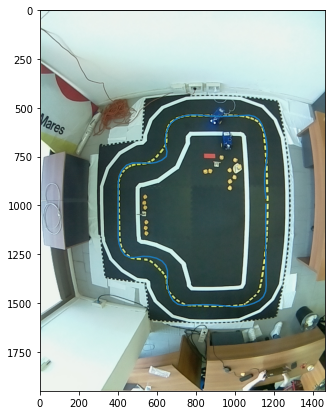

In [168]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.plot(*use_calibration(traj, env=env, img=img).T)